In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cf
projection = ccrs.Mercator()
crs = ccrs.PlateCarree()

import matplotlib.colors as mcolors
from src.queries.connected_components import compute_connected_components_bursts
from src.burst_detection.numba.grid_distributed import grid_bursts_distributed
import copy
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import HTML
import matplotlib.animation as animation
import warnings, os
import utils_notebook as utils

In [2]:
threshold = 3
grid_data_path="../data/SST/medi_1960_2021_processed_focused.nc"
parameter="sst"
n_jobs = 6
minimum_length = 1
maximum_length = 365
absolute_threshold = True
animate = False
export = True
filename_html="example_grid"
print("\033[1m"+"Parameters: "+ "\033[0m")
print(f" - threshold = {threshold}")
print(f" - grid_data_path = \"{grid_data_path}\"")
print(f" - parameter = {parameter}")
print(f" - n_jobs = {n_jobs}")
print(f" - animate = {animate}")
print(f" - export = {export}")
print(f" - filename_html = \"{filename_html}\"")

Parameters: 
 - threshold = 3
 - grid_data_path = "../data/SST/medi_1960_2021_processed_focused.nc"
 - parameter = sst
 - n_jobs = 6
 - animate = False
 - export = True
 - filename_html = "example_grid"


In [3]:
ds = xr.open_dataset(grid_data_path)[parameter]
time = ds.time
ts_date = pd.DatetimeIndex(time.values)
len_year = 365
n_year = len(ds.time) // len_year
lat = ds.lat.size
lon = ds.lon.size
lon_min = ds.lon.min().values
lon_max = ds.lon.max().values
lat_min = ds.lat.min().values
lat_max = ds.lat.max().values
values = ds.values.astype(np.float64)
first_year = ts_date[0].year
last_year = ts_date[-1].year
years = range(first_year, last_year+1)

In [4]:
grid_burst = grid_bursts_distributed(
    grid_data_path,
    n_jobs,
    n_year,
    len_year,
    threshold,
    parameter,
    minimum_length,
    maximum_length,
    absolute_threshold)

24/12/05 14:20:01 WARN Utils: Your hostname, coulaud resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
24/12/05 14:20:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 14:20:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Time taken: 66.86s


### Number of burst (after merging) per series

In [5]:
grid_count, grid_count_hot, grid_count_cold, grid_count_days_hot, grid_count_days_cold, coords = utils.compute_grid_counts(grid_burst, lat, lon, values)

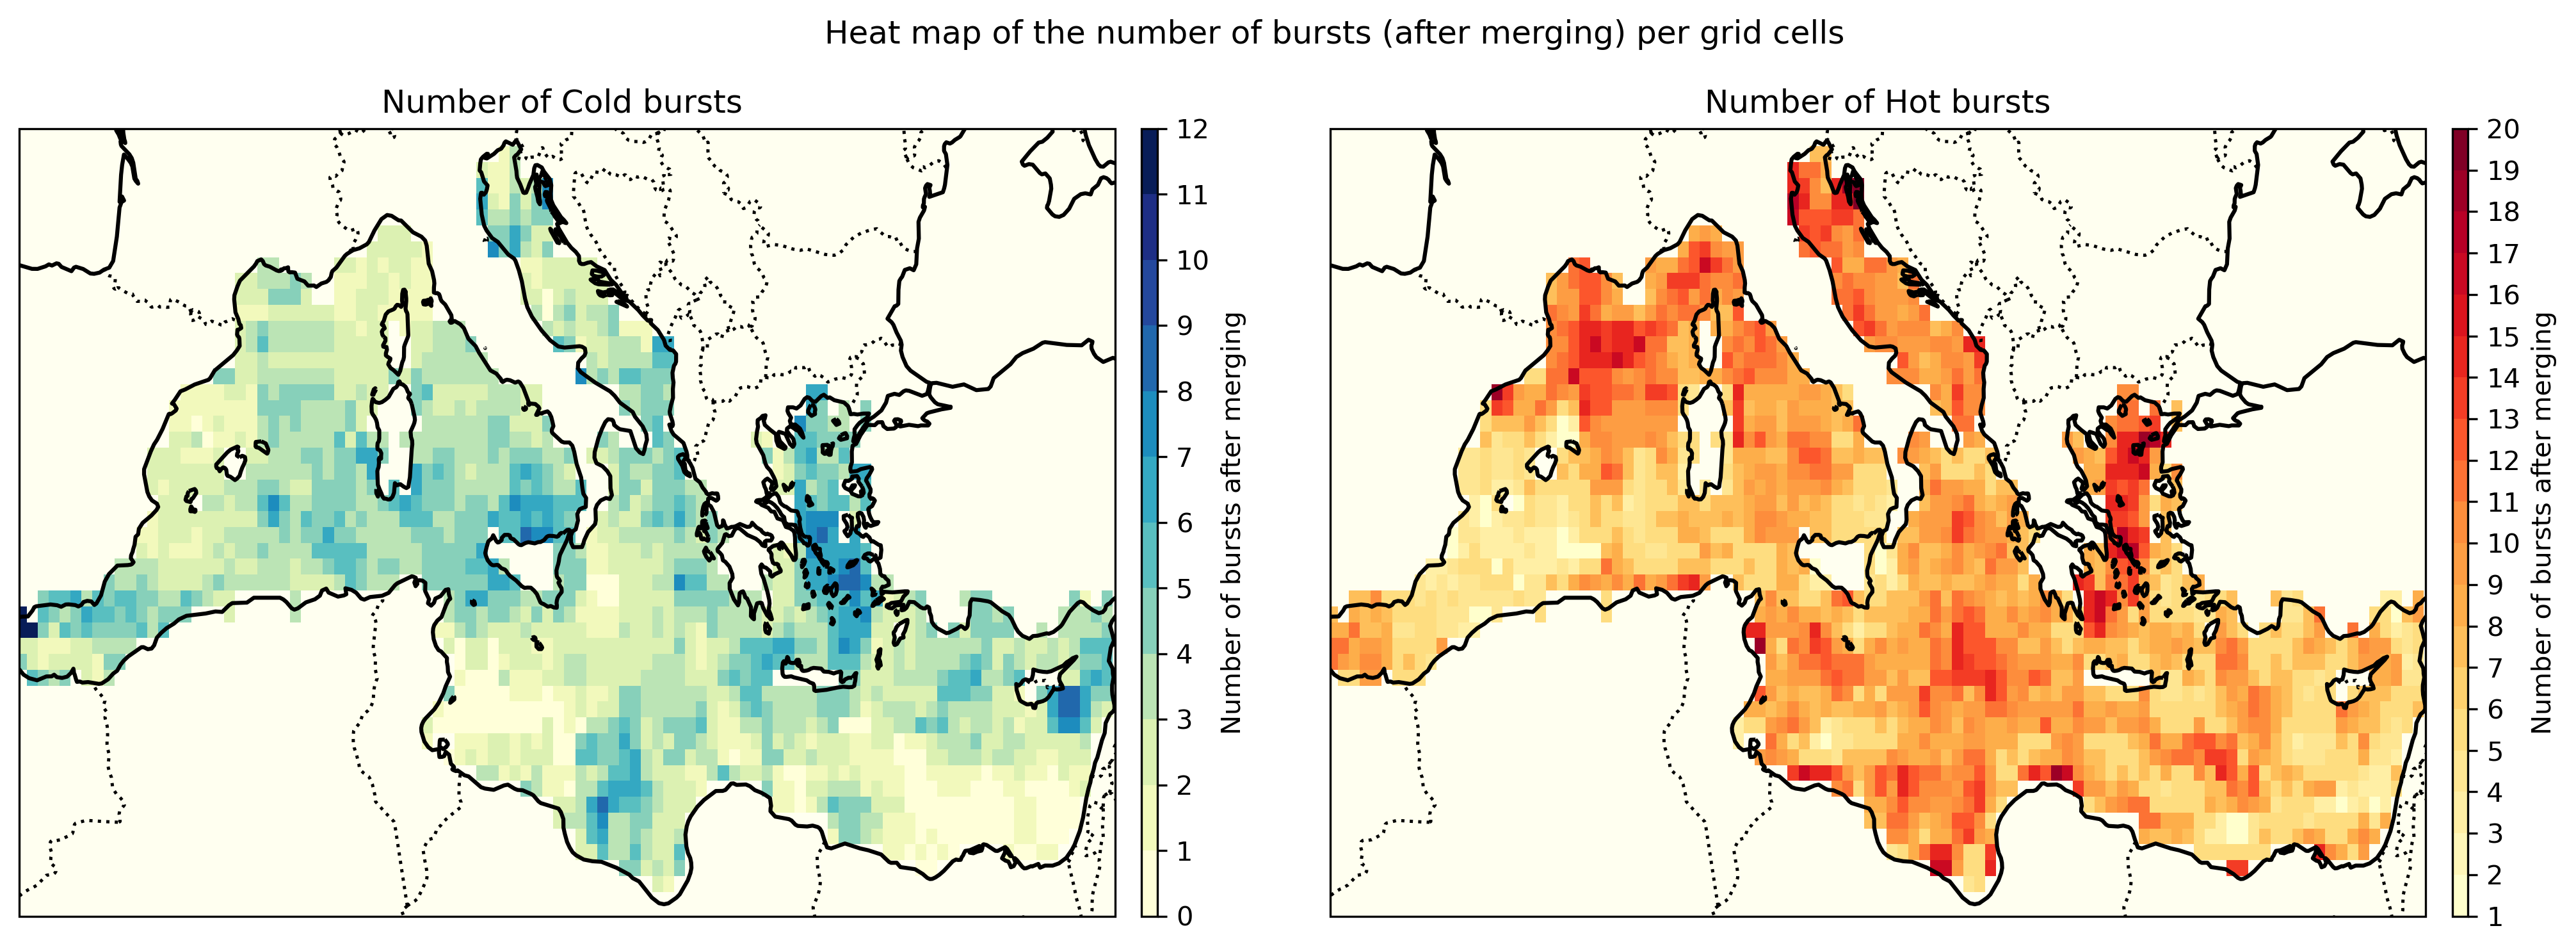

In [6]:
plt.figure(figsize=(14, 5), dpi=300)

# First subplot: Cold bursts
bounds_cold = np.arange(np.nanmin(grid_count_cold), np.nanmax(grid_count_cold)+1, 1)
if len(bounds_cold) > 1:
    ax1 = plt.subplot(1, 2, 1, projection=projection)

    cmap_cold = plt.cm.YlGnBu
    cmap_cold.set_bad(color="ivory")
    norm_cold = mcolors.BoundaryNorm(boundaries=bounds_cold, ncolors=cmap_cold.N) 
    img1 = ax1.imshow(grid_count_cold, cmap=cmap_cold, norm=norm_cold, extent=[lon_min, lon_max, lat_min, lat_max], 
                      transform=ccrs.PlateCarree(), origin='upper', aspect='auto')
    ax1.coastlines(resolution='50m', linewidth=1.5),ax1.add_feature(cf.BORDERS, linestyle=':', linewidth=1.2),ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    cbar1 = plt.colorbar(img1, ax=ax1, orientation='vertical', pad=0.02, aspect=50, boundaries=bounds_cold, ticks=bounds_cold)
    cbar1.set_label('Number of bursts after merging'), utils.hide_ax(ax1), ax1.set_title("Number of Cold bursts ")

# Second subplot: Hot bursts
bounds_hot = np.arange(np.nanmin(grid_count_hot), np.nanmax(grid_count_hot)+1, 1)
if len(bounds_hot) > 1:
    ax2 = plt.subplot(1, 2, 2, projection=projection)
    cmap_hot = plt.cm.YlOrRd
    cmap_hot.set_bad(color="ivory")
    norm_hot = mcolors.BoundaryNorm(boundaries=bounds_hot, ncolors=cmap_hot.N)
    img2 = ax2.imshow(grid_count_hot, cmap=cmap_hot, norm=norm_hot, extent=[lon_min, lon_max, lat_min, lat_max], 
                      transform=ccrs.PlateCarree(), origin='upper', aspect='auto')
    ax2.coastlines(resolution='50m', linewidth=1.5), ax2.add_feature(cf.BORDERS, linestyle=':', linewidth=1.2), ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    cbar2 = plt.colorbar(img2, ax=ax2, orientation='vertical', pad=0.02, aspect=50, boundaries=bounds_hot, ticks=bounds_hot)
    cbar2.set_label('Number of bursts after merging'), utils.hide_ax(ax2), ax2.set_title("Number of Hot bursts")

plt.suptitle("Heat map of the number of bursts (after merging) per grid cells"), plt.tight_layout()
plt.show()

In [7]:
plt.figure(figsize=(14, 5))
# First subplot: Cold bursts
if not np.isnan(np.max(grid_count_days_cold)):
    step = max( 1, int(np.nanmax(grid_count_days_cold)//20))
    bounds_cold = np.arange(np.nanmin(grid_count_days_cold), np.nanmax(grid_count_days_cold)+1, step)
    ax1 = plt.subplot(1, 2, 1, projection=projection)
    cmap_cold = plt.cm.YlGnBu
    cmap_cold.set_bad(color="ivory")
    norm_cold = mcolors.BoundaryNorm(boundaries=bounds_cold, ncolors=cmap_cold.N)
    img1 = ax1.imshow(grid_count_days_cold, cmap=cmap_cold, norm=norm_cold, extent=[lon_min, lon_max, lat_min, lat_max], 
                      transform=ccrs.PlateCarree(), origin='upper', aspect='auto')
    ax1.coastlines(resolution='50m', linewidth=1.5), ax1.add_feature(cf.BORDERS, linestyle=':', linewidth=1.2), ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    cbar1 = plt.colorbar(img1, ax=ax1, orientation='vertical', pad=0.02, aspect=50, boundaries=bounds_cold, ticks=bounds_cold)
    cbar1.set_label('Number of bursts days'), ax1.set_title("Number of Cold bursts days")

# Second subplot: Hot bursts
if not np.isnan(np.max(grid_count_days_hot)):
    step = max( 1, int(np.nanmax(grid_count_days_hot)//20))
    bounds_hot = np.arange(np.nanmin(grid_count_days_hot), np.nanmax(grid_count_days_hot)+1, step)
    ax2 = plt.subplot(1, 2, 2, projection=projection)
    cmap_hot = plt.cm.YlOrRd
    cmap_hot.set_bad(color="ivory")
    norm_hot = mcolors.BoundaryNorm(boundaries=bounds_hot, ncolors=cmap_hot.N)
    img2 = ax2.imshow(grid_count_days_hot, cmap=cmap_hot, norm=norm_hot, extent=[lon_min, lon_max, lat_min, lat_max], 
                      transform=ccrs.PlateCarree(), origin='upper', aspect='auto')
    ax2.coastlines(resolution='50m', linewidth=1.5), ax2.add_feature(cf.BORDERS, linestyle=':', linewidth=1.2), ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    cbar2 = plt.colorbar(img2, ax=ax2, orientation='vertical', pad=0.02, aspect=50, boundaries=bounds_hot, ticks=bounds_hot)
    cbar2.set_label('Number of bursts days'), ax2.set_title("Number of Hot bursts days")
plt.suptitle("Heat map of the number of days belonging to bursts per grid cells"), plt.tight_layout()
plt.show()

<Figure size 1400x500 with 0 Axes>

### Connected Components

In [8]:
connected_components_bursts = compute_connected_components_bursts(grid_burst, 1)
ccs = [cc for cc in connected_components_bursts if len(list(set(cc))) >= 5]
print(f"In total there are {len(connected_components_bursts)} connected component(s). If we keep connected components that have at least 5 components (5 anomalies) we have {len(ccs)} cluster(s)") 

In total there are 1255 connected component(s). If we keep connected components that have at least 5 components (5 anomalies) we have 594 cluster(s)


In [9]:
daylies_hot, daylies_cold, series_hot, series_cold = utils.compute_grid_bars(ts_date, grid_burst, coords)

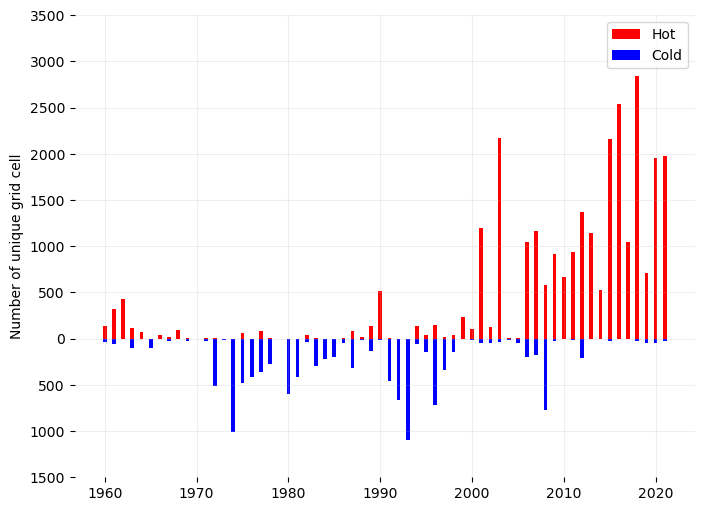

In [10]:
data = {'year': years,
        'hot': series_hot,
        'cold': -series_cold}

plt.figure(figsize=(8, 6)), plt.grid(alpha=0.2)
plt.bar(data['year'], data['hot'], width=0.4, color='red', label='Hot')
plt.bar(data['year'], data['cold'], width=0.4, color='blue', label='Cold')
plt.ylabel('Number of unique grid cell')
ax = plt.gca()
ax.set_yticks(ax.get_yticks().tolist())
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
labels = [int(abs(e)) for e in ax.get_yticks()]
ax.set_yticklabels(labels), plt.legend()
for pos in ['right', 'top', 'bottom', 'left']: plt.gca().spines[pos].set_visible(False)
plt.show()

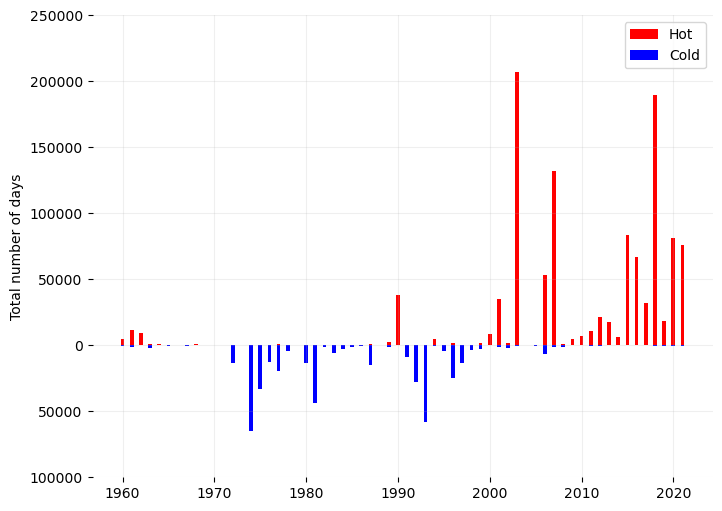

In [11]:
data = {'date': ts_date,
        'hot': daylies_hot,
        'cold': -daylies_cold}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year


yearly_sum = df.groupby('year')[['hot', 'cold']].sum().reset_index()

plt.figure(figsize=(8, 6)), plt.grid(alpha=0.2)
plt.bar(yearly_sum['year'], yearly_sum['hot'], width=0.4, color='red', label='Hot')
plt.bar(yearly_sum['year'], yearly_sum['cold'], width=0.4, color='blue', label='Cold')
plt.ylabel('Total number of days')
ax = plt.gca()
ax.set_yticks(ax.get_yticks().tolist()), ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
labels = [int(abs(e)) for e in ax.get_yticks()]
ax.set_yticklabels(labels), plt.legend()
for pos in ['right', 'top', 'bottom', 'left']: plt.gca().spines[pos].set_visible(False)
plt.show()

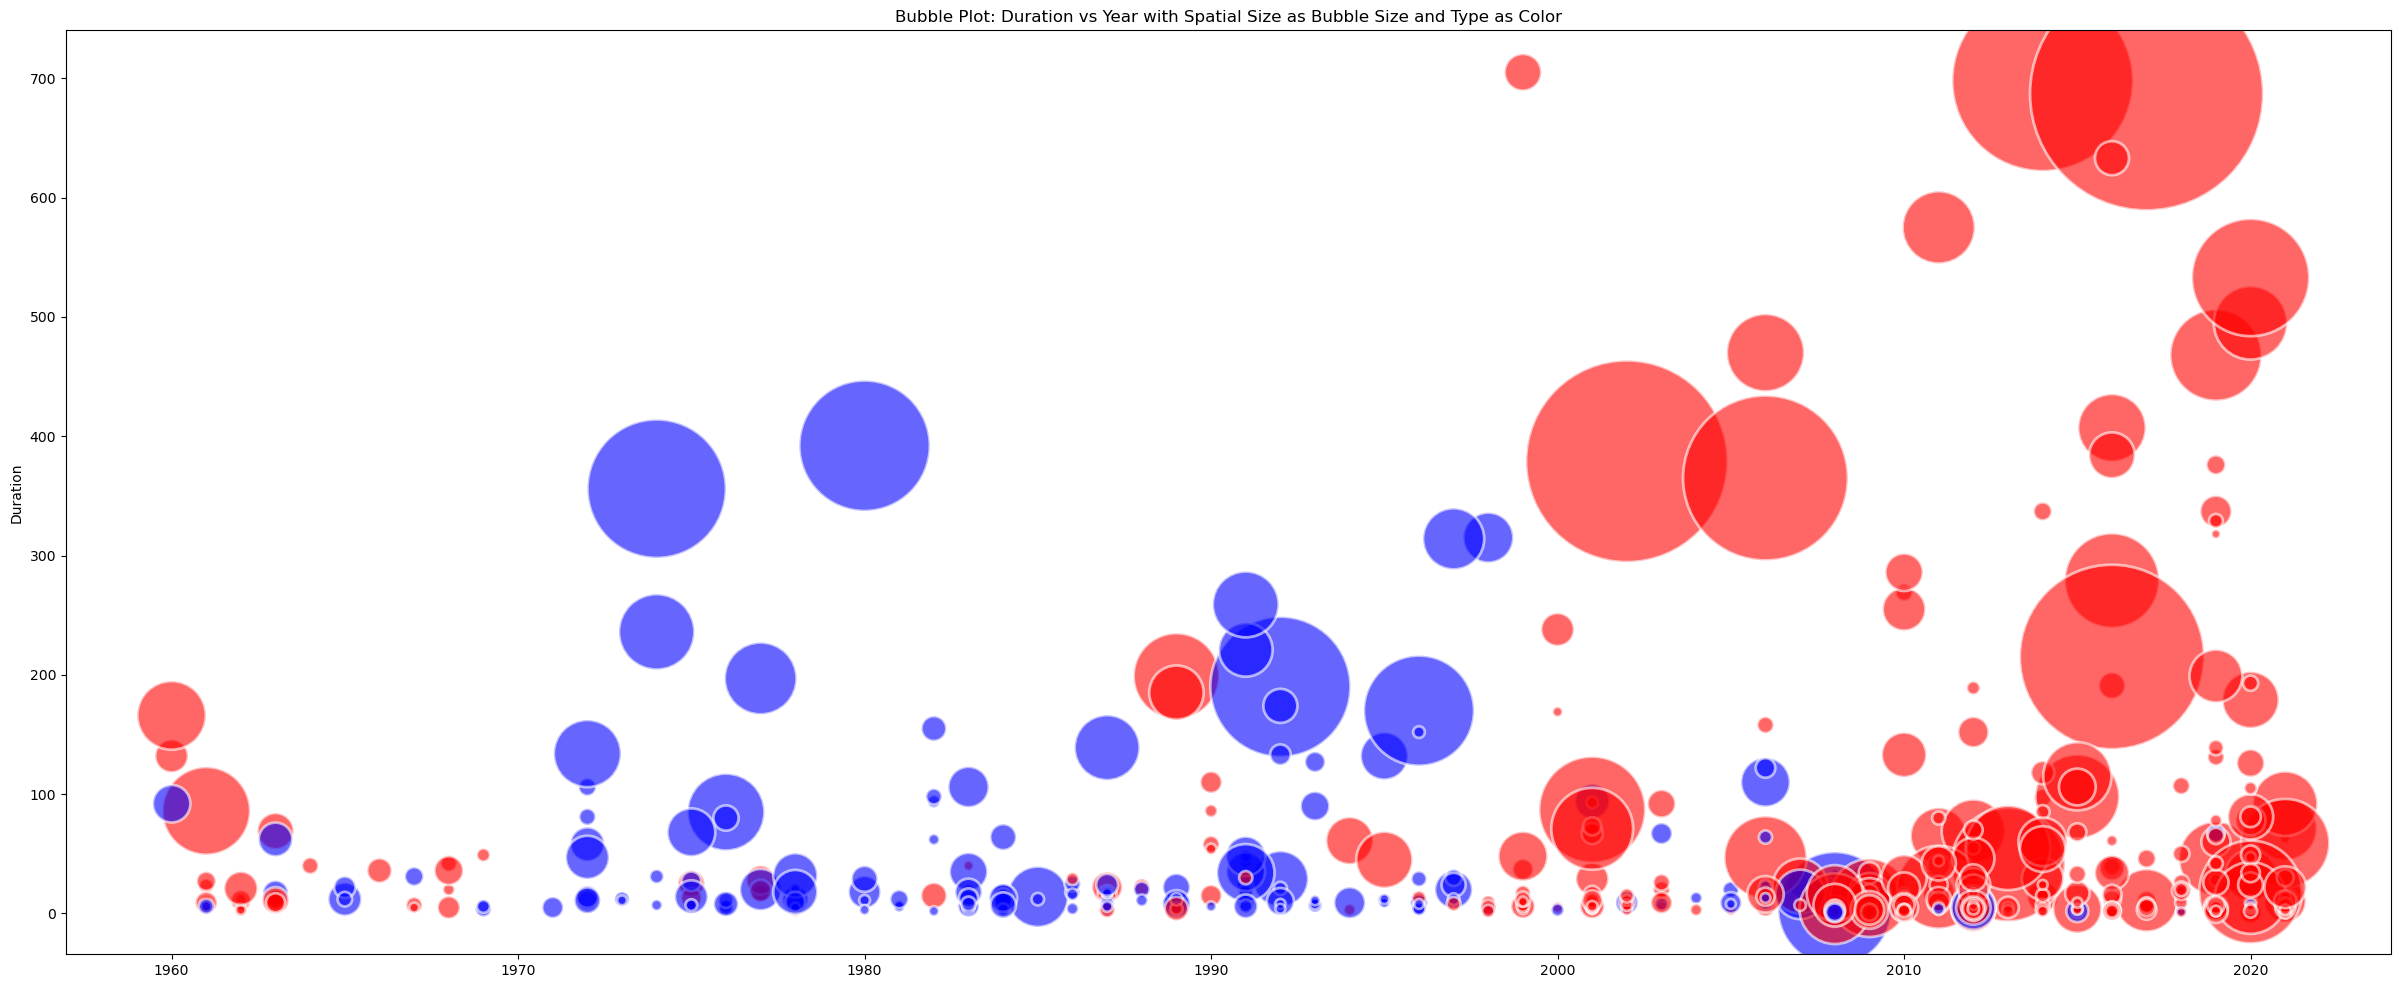

In [12]:
cc_stats, grid_start_5, grid_start_10, grid_start_15, grid_start_20 = utils.compute_cc_stats(grid_burst, ccs, n_year, first_year, lat, lon, coords)
    
df_cc = pd.DataFrame(cc_stats, columns=['Duration', 'Spatial Size', 'Start Year', 'Type'])
# Setting the color based on Type
colors = df_cc['Type'].map({1: 'red', -1: 'blue'})

# Creating the bubble plot
plt.figure(figsize=(30, 12))
plt.scatter(df_cc['Start Year'], df_cc['Duration'], s=df_cc['Spatial Size']*10, c=colors, alpha=0.6, edgecolors="w", linewidth=2)

# Adding labels and title
#plt.xlabel('Year')
plt.ylabel('Duration')
plt.title('Bubble Plot: Duration vs Year with Spatial Size as Bubble Size and Type as Color')
plt.show()

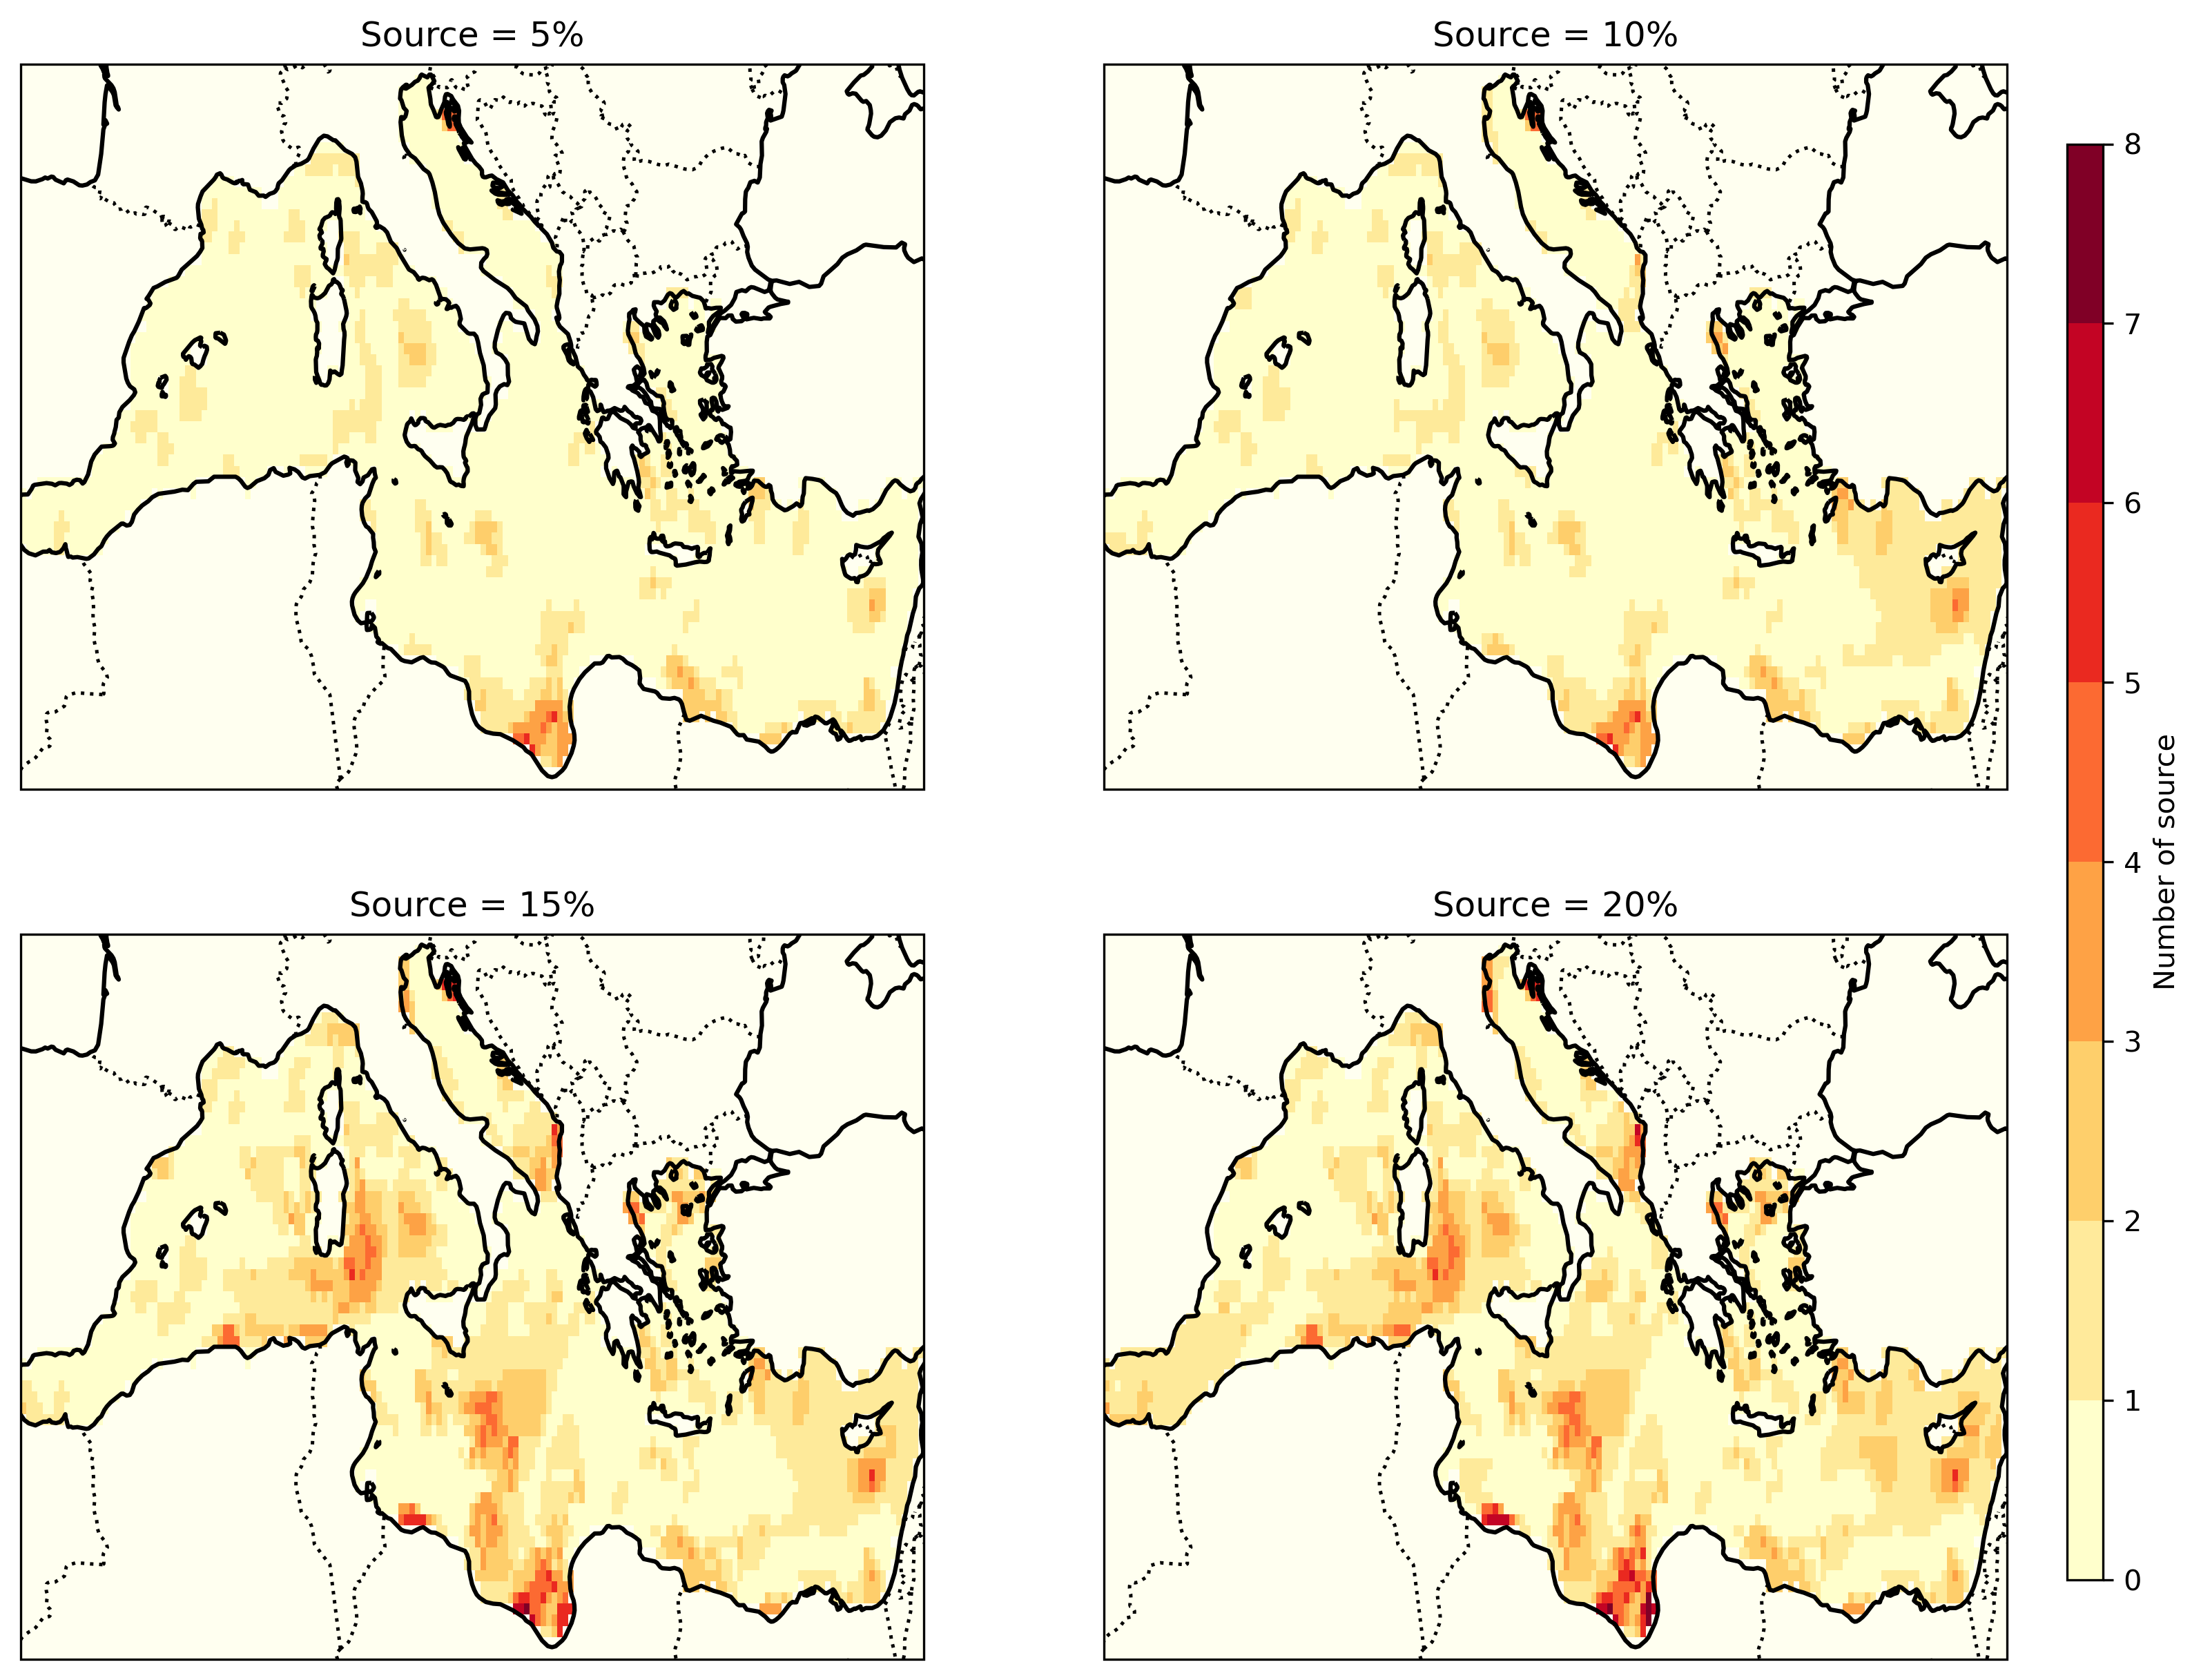

In [13]:
percentages = [5, 10, 15, 20]
grids = [grid_start_5, grid_start_10, grid_start_15, grid_start_20]  # List of grid data for each percentage

fig, axes = plt.subplots(2, 2, figsize=(15, 10), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
global_min = np.nanmin([np.nanmin(grid) for grid in grids])
global_max = np.nanmax([np.nanmax(grid) for grid in grids])
bounds = np.arange(global_min, global_max + 1, 1)
cmap = plt.cm.YlOrRd
cmap.set_bad(color="ivory")
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

for ax, grid, perc in zip(axes.flat, grids, percentages):

    
    # Plot the data on each axis
    img = ax.imshow(grid, cmap=cmap, norm=norm, extent=[lon_min, lon_max, lat_min, lat_max], 
                    transform=ccrs.PlateCarree(), origin='upper', aspect='auto')
    
    # Add coastlines and borders
    ax.coastlines(resolution='50m', linewidth=1.5)
    ax.add_feature(cf.BORDERS, linestyle=':', linewidth=1.2)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    # Title for each subplot
    ax.set_title(f"Source = {perc}%")
    
    # Remove axis labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

# Add a single colorbar for all subplots
cbar = fig.colorbar(img, ax=axes, orientation='vertical', pad=0.025, aspect=40, 
                    boundaries=bounds, ticks=bounds, shrink=0.9)
cbar.set_label('Number of source')

# Show the figure
plt.show()


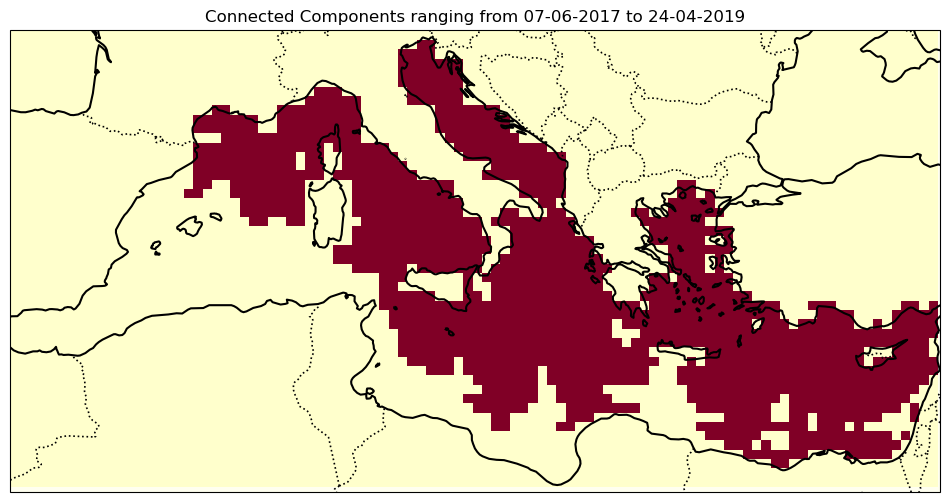

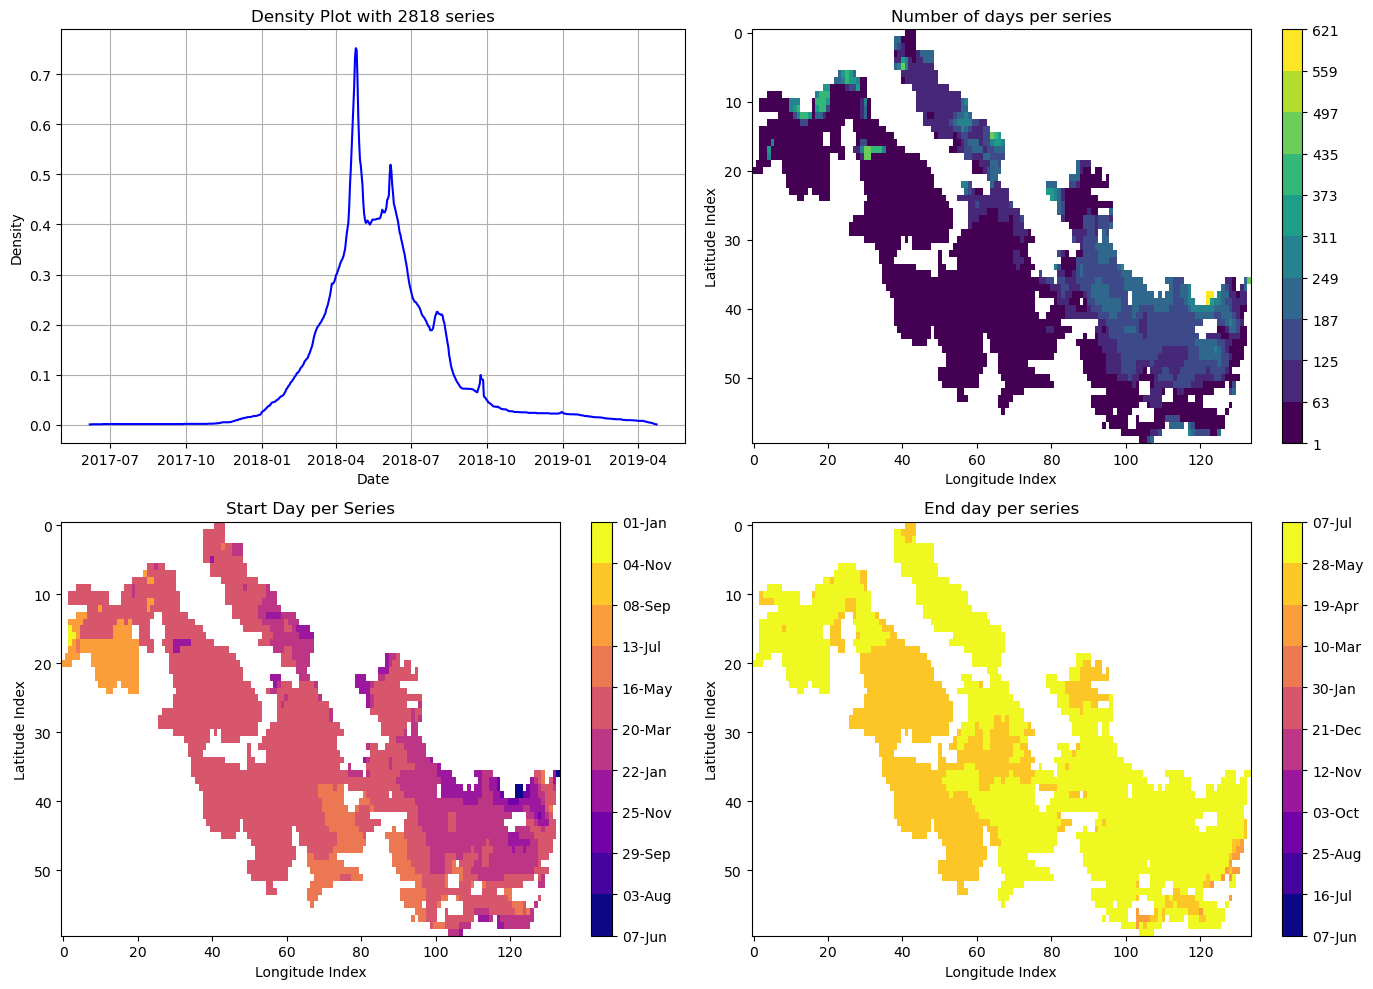

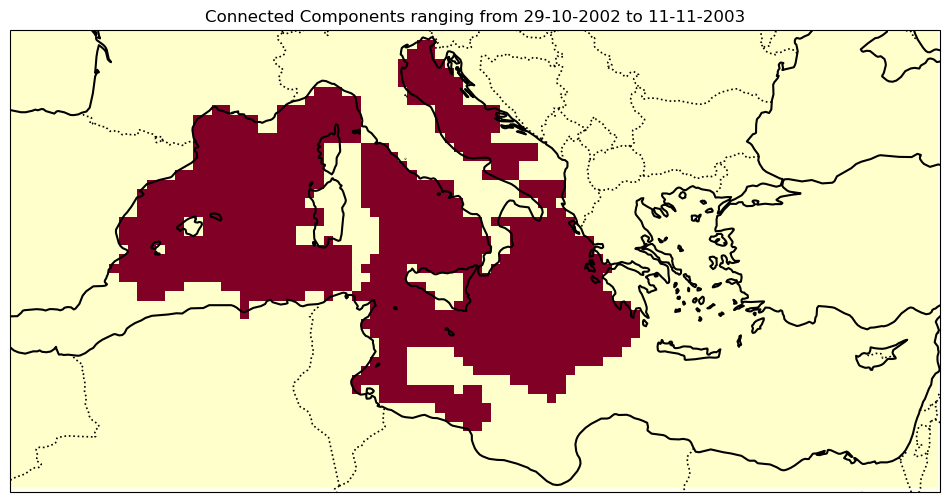

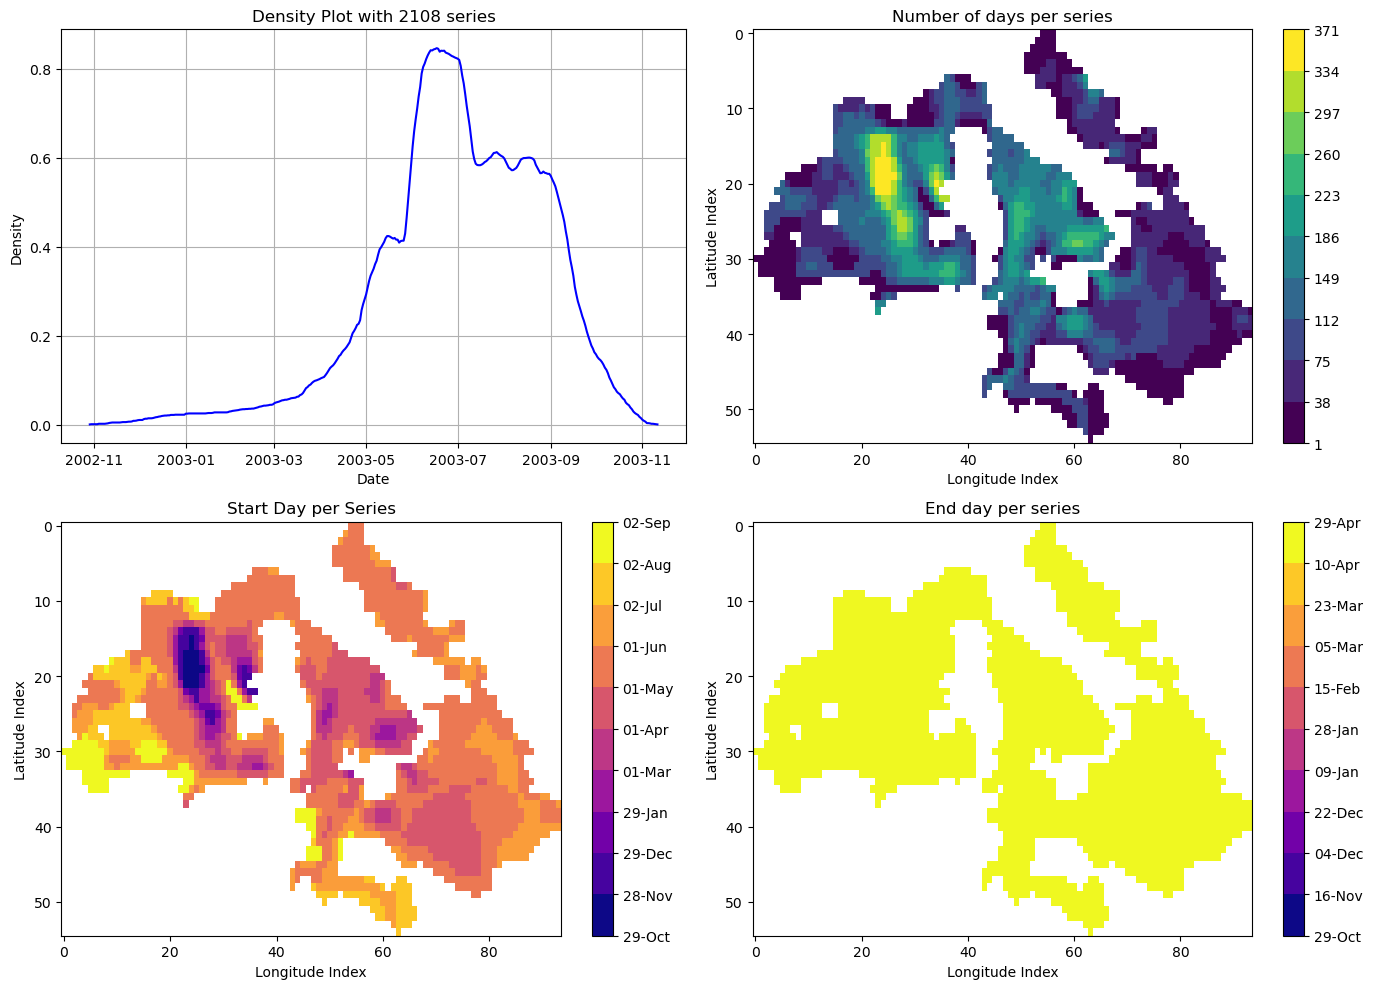

In [14]:
ccs.sort(key=len)
ccs.reverse()
for i, cc in enumerate(ccs[:2]):
    utils.show_connected_component(cc, n_year, ts_date, lat, lon, grid_burst, values, lon_min, lon_max, lat_min, lat_max)

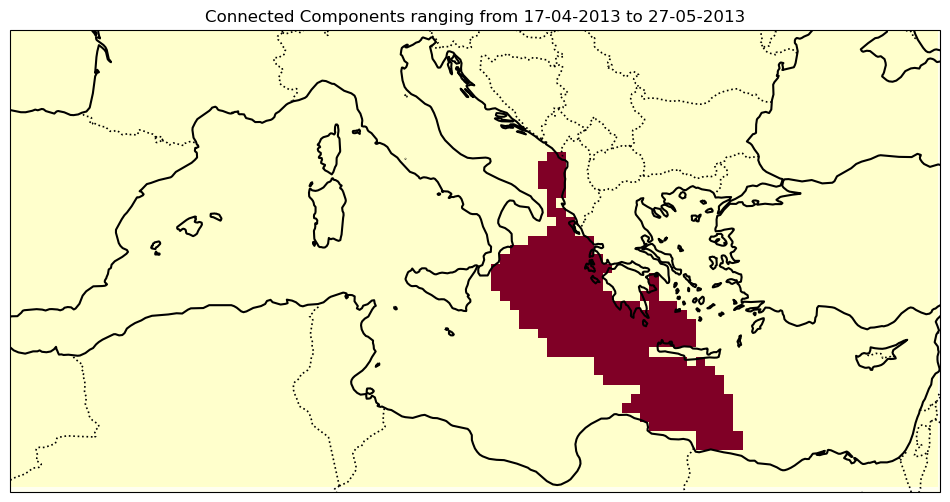

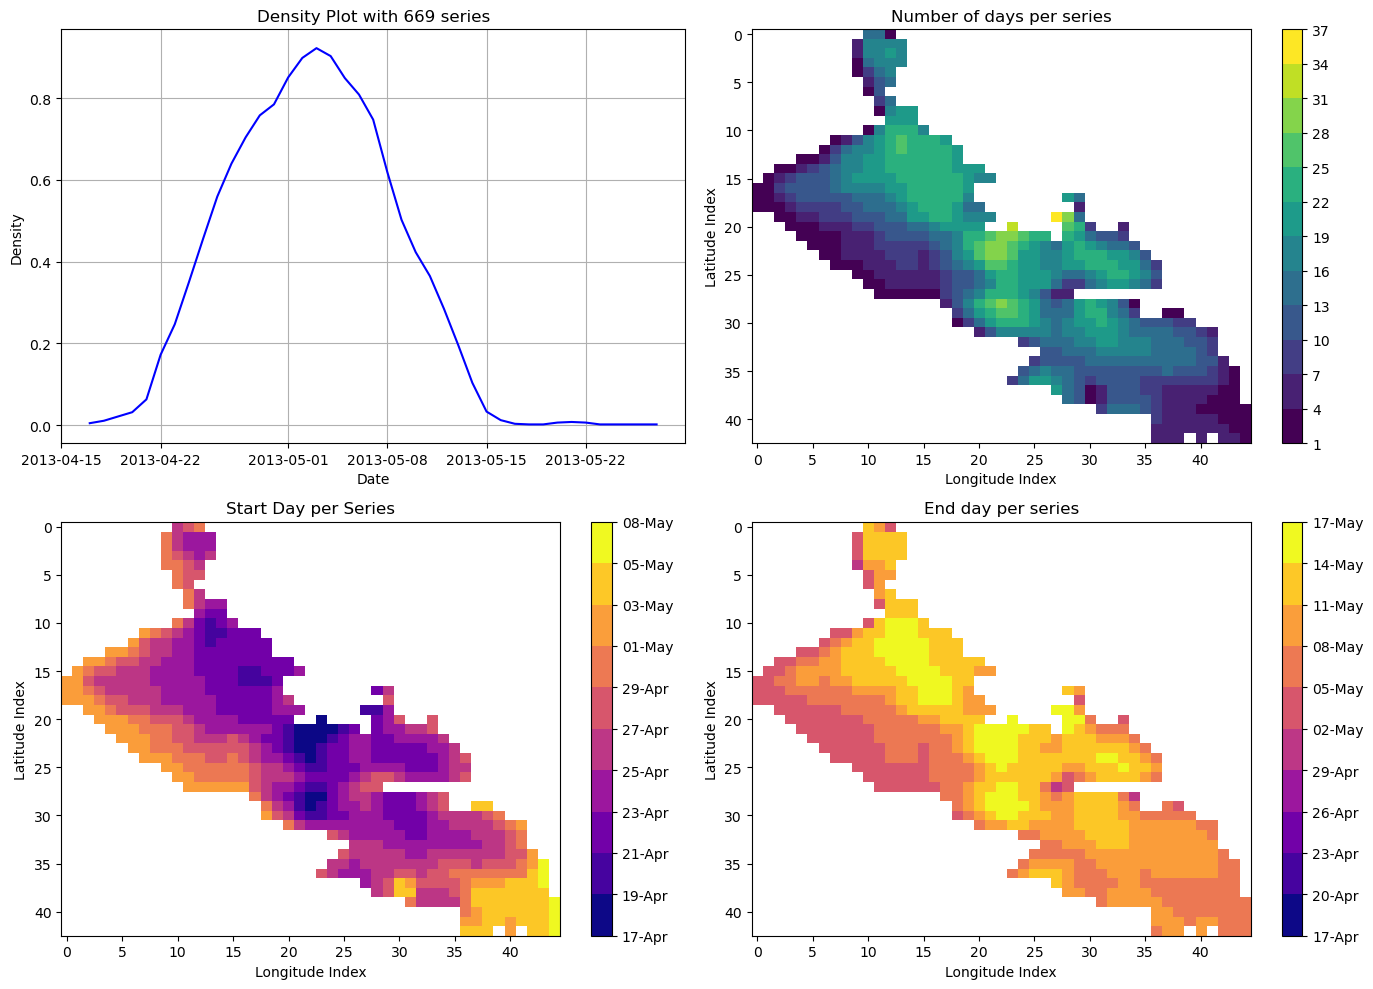

In [15]:
utils.show_connected_component(ccs[9], n_year, ts_date, lat, lon, grid_burst, values, lon_min, lon_max, lat_min, lat_max)

In [16]:
if animate:
    anim = utils.cc_time_travel(ccs[9], ts_date, grid_burst, lat, lon, values)
    HTML(anim.to_jshtml())
    FFwriter = animation.FFMpegWriter(fps=3)
    anim.save('connected_component_time_travel.mp4', writer = FFwriter)


## Time Travel

In [17]:
if animate:
    plt.rcParams['animation.embed_limit'] = 2**128
    start = np.where(ts_date == "01-01-2010")[0][0]
    grid_count = np.zeros((len(ts_date)-start, lat,lon))
    grid_count[:] = np.nan
    for (i,j) in coords:
        grid_count[:, i,j] = 0
        
    for (i,j) in coords:
        for burst in grid_burst[i,j]:
            s,e,z = burst
            if e >= start:
                bend = e - start
                bstart = e - start
                grid_count[bstart:bend+1,i,j] = int(np.sign(z))
    
    grid_weekly_count = np.zeros((1+(len(ts_date)-start)//7, lat,lon))
    grid_weekly_count[:] = np.nan
    for (i,j) in coords:
        grid_weekly_count[:, i,j] = 0
    for i in range(grid_count.shape[1]):
        for j in range(grid_count.shape[2]):
            for w in range(grid_weekly_count.shape[0]):
                grid_weekly_count[w,i,j] = np.sign(np.add.reduce(grid_count[w*7:(w+1)*7,i,j]))
                
    fig, ax = plt.subplots(figsize=(20, 10))
    cmap = ListedColormap(['blue', 'white', 'red'])  # Colors for -1, 0, and 1
    norm = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap.N)  
    cmap.set_bad(color="darkgrey")
    
    # Initialize the image plot
    img = ax.imshow(grid_weekly_count[0], cmap=cmap, norm=norm)
    plt.close()
    
    # Add text element for displaying the current date
    date_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    formatted_dates = [f'Date: {date.strftime("%Y-%m-%d")}' for date in ts_date[start:start + len(grid_weekly_count) * 7:7]]
    # Update function for animation
    def update(frame):
        img.set_array(grid_weekly_count[frame])
        date_text.set_text(formatted_dates[frame])
        return img, date_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(grid_weekly_count), interval=200, blit=False, cache_frame_data=False)
    with open("myvideo_weekly.html", "w") as f:
        print(anim.to_jshtml(), file=f)

    FFwriter = animation.FFMpegWriter()
    anim.save('weekly_time_travel.mp4', writer = FFwriter)
    HTML(anim.to_jshtml())

In [18]:
%%capture output
if export:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        os.system('jupyter nbconvert --no-input --output ' + filename_html + ' --to html ' + "paper_grid.ipynb")

[NbConvertApp] Converting notebook paper_grid.ipynb to html
[NbConvertApp] Writing 275606 bytes to example_grid.html
